In [1]:
import os
from matplotlib import pyplot as plt
from PIL import Image

data_dir = "/home/badari/Thesis_Depth/Analysis/grasp1b_dataset_organized/"

In [4]:
val_dir = os.path.join(data_dir, "val")
val_dir

'/home/badari/Thesis_Depth/Analysis/grasp1b_dataset_organized/val'

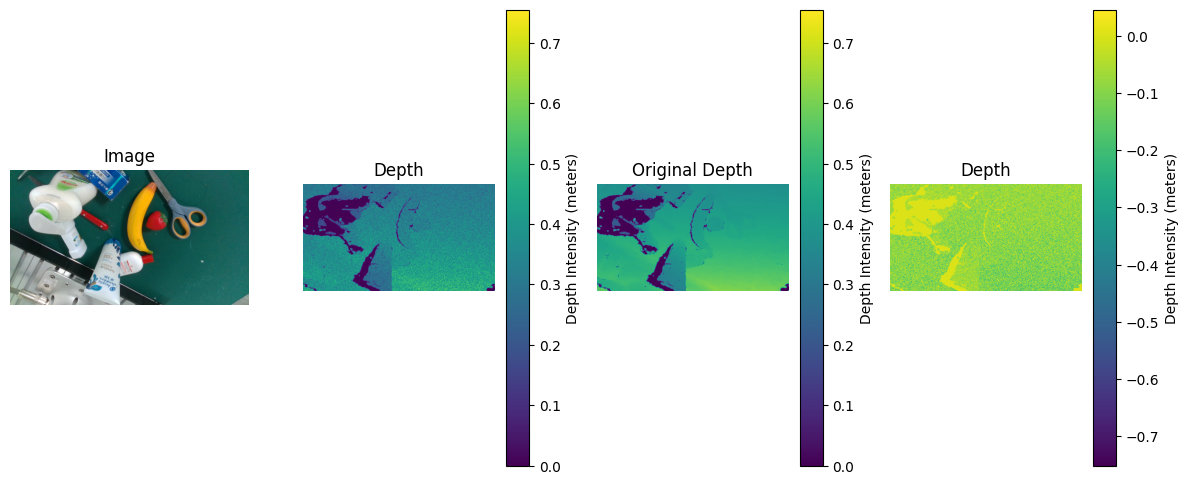

Depth shape:  (720, 1280) Minimum depth:  0.0 Maximum depth:  0.755


In [31]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import generic_filter
import cv2

def augment_depth_image(depth_image, missing_ratio=0.2, noise_std=0.01):
    """
    Augment a depth image by introducing missing data and noise.

    Parameters:
    - depth_image: numpy array of shape (H, W) representing the depth image.
    - missing_ratio: float, proportion of pixels to mask as missing.
    - noise_std: float, standard deviation of Gaussian noise to add.

    Returns:
    - Augmented depth image.
    """
    augmented_image = depth_image.copy()

    # Simulate missing data
    mask = np.random.rand(*depth_image.shape) < missing_ratio
    augmented_image[mask] = 0  # Set missing data to 0 (or another placeholder)

    # Add Gaussian noise
    noise = np.random.normal(0, noise_std, depth_image.shape)
    augmented_image += noise

    # Clip values to valid range
    augmented_image = np.clip(augmented_image, 0, np.max(depth_image))

    return augmented_image

# Iterate through the validation directory
for img_path in os.listdir(os.path.join(val_dir, "depth")):
    dep_path = os.path.join(val_dir, "depth", img_path)
    img_path = os.path.join(val_dir, "images", img_path)

    # depth = Image.open(dep_path)
    # depth = np.array(depth) / 1000.0  # Scale depth values to meters
    depth = cv2.imread(dep_path, cv2.IMREAD_ANYDEPTH)/1000.0
    depth = depth.astype(np.float32)

    # replace 0 with max depth value

    org_depth = depth.copy()

    # depth[depth == 0] = np.average(depth)

    depth = augment_depth_image(depth, missing_ratio=0.2, noise_std=0.01)

    # pre-process the depth image


    img = Image.open(img_path)

    fig, ax = plt.subplots(1, 4, figsize=(12, 6))

    # Display the RGB image
    ax[0].imshow(img)
    ax[0].set_title("Image")
    ax[0].axis("off")

    # Display the depth image with a colormap
    im = ax[1].imshow(depth, cmap='viridis')
    ax[1].set_title("Depth")
    ax[1].axis("off")

    # Add a colorbar to the depth plot
    cbar = fig.colorbar(im, ax=ax[1], orientation='vertical', shrink=0.8)
    cbar.set_label('Depth Intensity (meters)')

    # Display the depth image with a colormap
    im = ax[2].imshow(org_depth, cmap='viridis')
    ax[2].set_title("Original Depth")
    ax[2].axis("off")

    # Add a colorbar to the depth plot
    cbar = fig.colorbar(im, ax=ax[2], orientation='vertical', shrink=0.8)
    cbar.set_label('Depth Intensity (meters)')

    # Display the depth image with a colormap
    im = ax[3].imshow(depth - org_depth, cmap='viridis')
    ax[3].set_title("Depth")
    ax[3].axis("off")

    # Add a colorbar to the depth plot
    cbar = fig.colorbar(im, ax=ax[3], orientation='vertical', shrink=0.8)
    cbar.set_label('Depth Intensity (meters)')

    plt.tight_layout()
    plt.show()

    print("Depth shape: ", depth.shape, "Minimum depth: ", np.min(depth), "Maximum depth: ", np.max(depth))

    break



Processing: scene_0090_0172.png
Before preprocessing:
Valid depth range: 219.00 - 755.00
Invalid pixels: 107260 (11.64%)

After preprocessing:
Valid depth range: 0.00 - 753.83
Invalid pixels: 0 (0.00%)


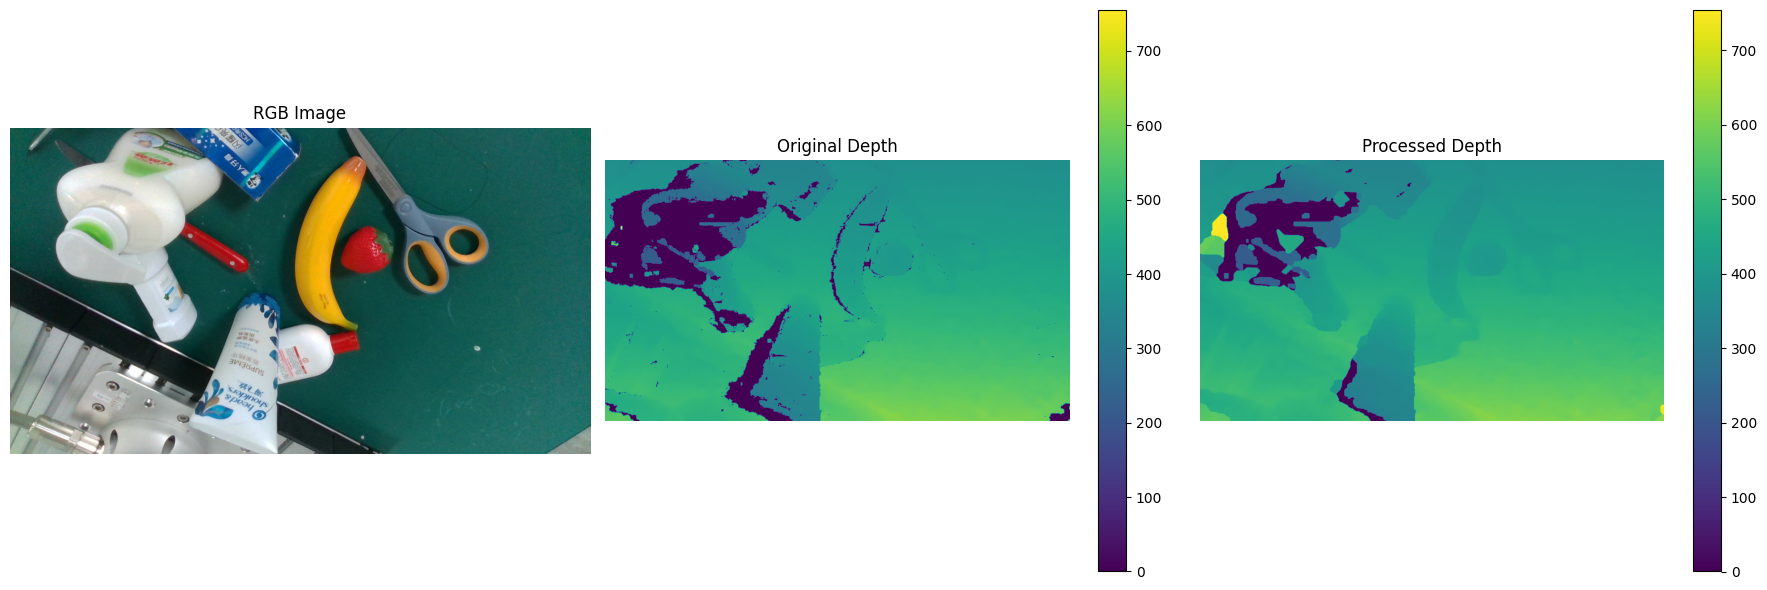

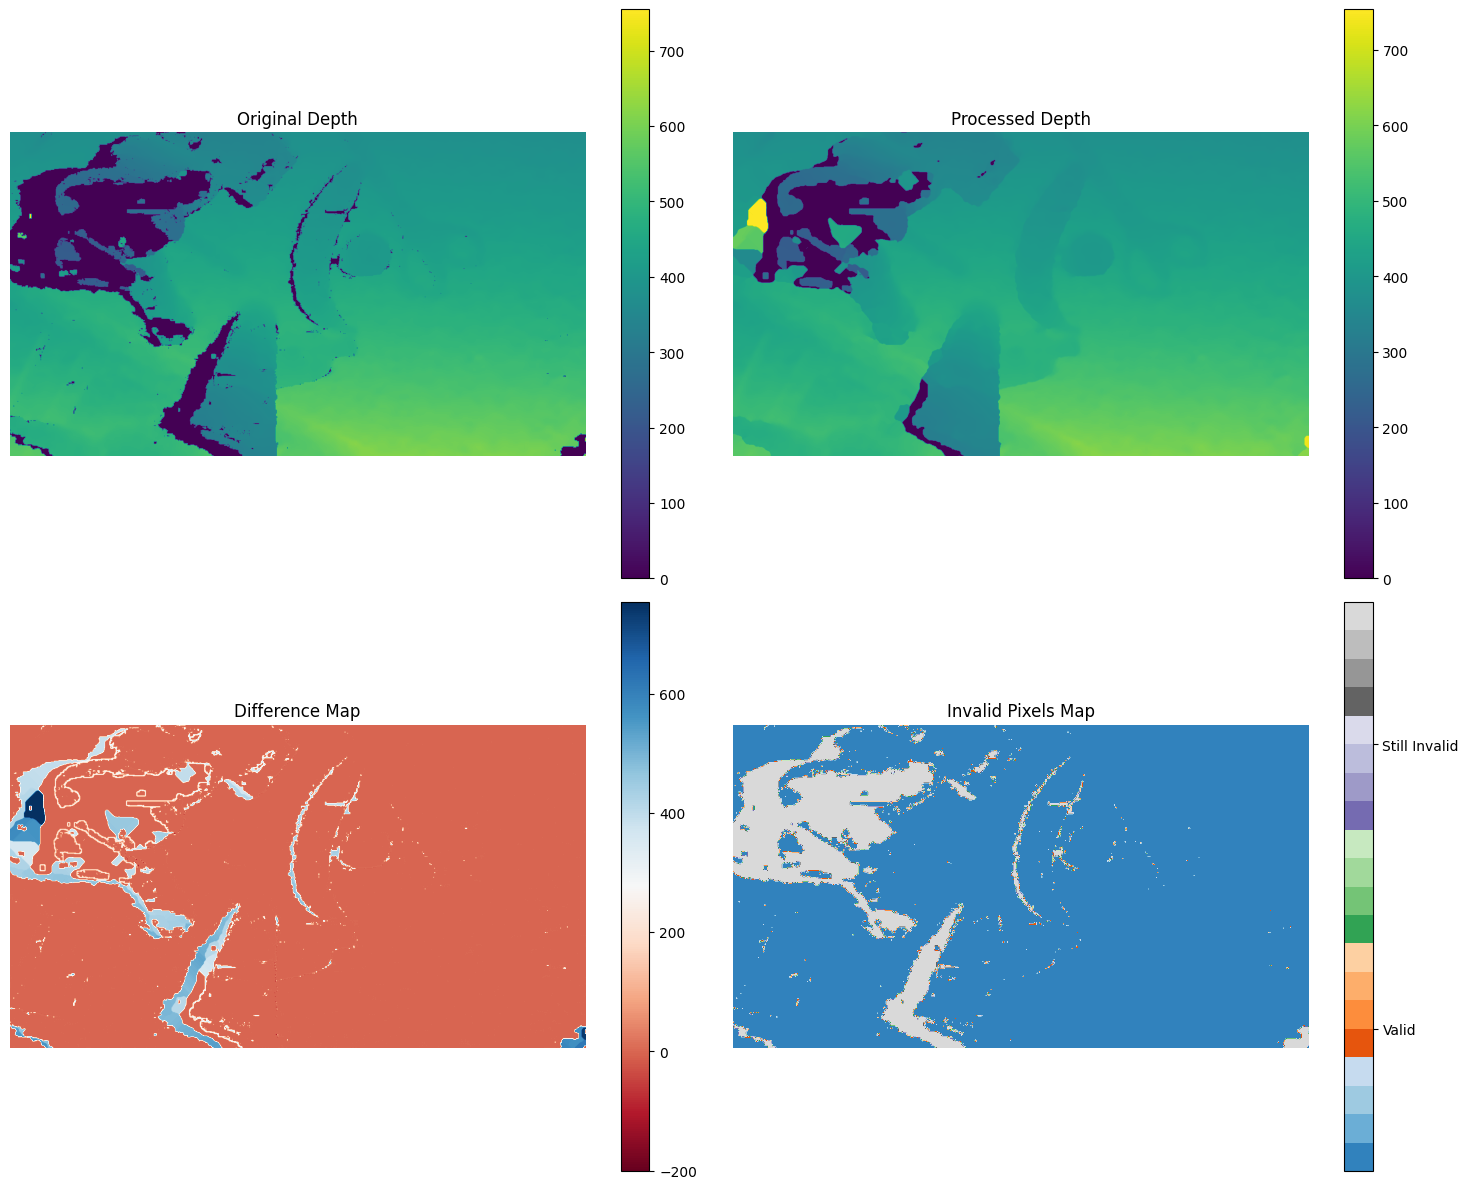

Depth shape: (720, 1280)
Original depth range: 219.00 - 755.00
Processed depth range: 0.00 - 753.83


In [22]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import generic_filter
import cv2

def preprocess_depth(depth_img):
    """
    Comprehensive depth image preprocessing
    Args:
        depth_img: Raw depth image (numpy array)
    Returns:
        Preprocessed depth image
    """
    # Convert to float32 if not already
    depth = depth_img.astype(np.float32)
    
    # 1. Create mask for invalid/zero values
    invalid_mask = (depth == 0)
    
    # Print statistics before preprocessing
    valid_depth = depth[~invalid_mask]
    if valid_depth.size > 0:
        print(f"Before preprocessing:")
        print(f"Valid depth range: {np.min(valid_depth):.2f} - {np.max(valid_depth):.2f}")
        print(f"Invalid pixels: {np.sum(invalid_mask)} ({(np.sum(invalid_mask)/depth.size)*100:.2f}%)")
    
    # 2. Apply bilateral filter to reduce noise while preserving edges
    depth_filtered = cv2.bilateralFilter(depth, d=5, sigmaColor=50, sigmaSpace=50)
    
    # 3. Fill invalid values using morphological operations
    kernel = np.ones((5,5), np.uint8)
    depth_filled = depth_filtered.copy()
    
    # Iterate until no more holes can be filled
    prev_invalid = np.sum(invalid_mask)
    while True:
        # Dilate valid depth values
        valid_mask = ~(depth_filled == 0)
        depth_filled[invalid_mask] = cv2.dilate(depth_filled, kernel, iterations=1)[invalid_mask]
        
        # Update invalid mask
        invalid_mask = (depth_filled == 0)
        if np.sum(invalid_mask) >= prev_invalid:
            break
        prev_invalid = np.sum(invalid_mask)
    
    # 4. Remove outliers using median filter
    depth_median = cv2.medianBlur(depth_filled.astype(np.float32), 5)
    
    # 5. Remove flying pixels
    kernel_small = np.ones((3,3), np.uint8)
    valid_mask = cv2.erode((depth_median > 0).astype(np.uint8), kernel_small) > 0
    depth_final = depth_median.copy()
    depth_final[~valid_mask] = 0
    
    # Print statistics after preprocessing
    valid_depth_final = depth_final[depth_final > 0]
    if valid_depth_final.size > 0:
        print(f"\nAfter preprocessing:")
        print(f"Valid depth range: {np.min(valid_depth_final):.2f} - {np.max(valid_depth_final):.2f}")
        print(f"Invalid pixels: {np.sum(depth_final == 0)} ({(np.sum(depth_final == 0)/depth_final.size)*100:.2f}%)")
    
    return depth_final

def visualize_depth_processing(original_depth, processed_depth):
    """
    Visualize original and processed depth images
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Original depth
    im1 = axes[0,0].imshow(original_depth, cmap='viridis')
    axes[0,0].set_title('Original Depth')
    axes[0,0].axis('off')
    plt.colorbar(im1, ax=axes[0,0])
    
    # Processed depth
    im2 = axes[0,1].imshow(processed_depth, cmap='viridis')
    axes[0,1].set_title('Processed Depth')
    axes[0,1].axis('off')
    plt.colorbar(im2, ax=axes[0,1])
    
    # Difference map
    diff = processed_depth - original_depth
    im3 = axes[1,0].imshow(diff, cmap='RdBu')
    axes[1,0].set_title('Difference Map')
    axes[1,0].axis('off')
    plt.colorbar(im3, ax=axes[1,0])
    
    # Invalid pixels visualization
    invalid_orig = original_depth == 0
    invalid_proc = processed_depth == 0
    invalid_map = np.zeros_like(original_depth, dtype=np.uint8)
    invalid_map[invalid_orig & invalid_proc] = 1  # Still invalid after processing
    invalid_map[invalid_orig & ~invalid_proc] = 2  # Fixed by processing
    invalid_map[~invalid_orig & invalid_proc] = 3  # New invalid pixels
    
    im4 = axes[1,1].imshow(invalid_map, cmap='tab20c')
    axes[1,1].set_title('Invalid Pixels Map')
    axes[1,1].axis('off')
    cbar = plt.colorbar(im4, ax=axes[1,1], ticks=[0.5, 1.5, 2.5, 3.5])
    cbar.set_ticklabels(['Valid', 'Still Invalid', 'Fixed', 'New Invalid'])
    
    plt.tight_layout()
    plt.show()

def process_depth_dataset(val_dir):
    """
    Process all depth images in the dataset
    """
    for img_path in os.listdir(os.path.join(val_dir, "depth")):
        dep_path = os.path.join(val_dir, "depth", img_path)
        img_path = os.path.join(val_dir, "images", img_path)
        
        try:
            # Load depth image
            depth = cv2.imread(dep_path, cv2.IMREAD_ANYDEPTH)
            if depth is None:
                print(f"Failed to load depth image: {dep_path}")
                continue
                
            # Load RGB image
            img = Image.open(img_path)
            
            print(f"\nProcessing: {os.path.basename(dep_path)}")
            
            # Preprocess depth image
            processed_depth = preprocess_depth(depth)
            
            # Visualize results
            fig, ax = plt.subplots(1, 3, figsize=(18, 6))
            
            # Display the RGB image
            ax[0].imshow(img)
            ax[0].set_title("RGB Image")
            ax[0].axis("off")
            
            # Display original depth
            im1 = ax[1].imshow(depth, cmap='viridis')
            ax[1].set_title("Original Depth")
            ax[1].axis("off")
            plt.colorbar(im1, ax=ax[1])
            
            # Display processed depth
            im2 = ax[2].imshow(processed_depth, cmap='viridis')
            ax[2].set_title("Processed Depth")
            ax[2].axis("off")
            plt.colorbar(im2, ax=ax[2])
            
            plt.tight_layout()
            plt.show()
            
            # Show detailed processing visualization
            visualize_depth_processing(depth, processed_depth)
            
            # Print shape and range information
            print(f"Depth shape: {depth.shape}")
            print(f"Original depth range: {np.min(depth[depth > 0]):.2f} - {np.max(depth):.2f}")
            print(f"Processed depth range: {np.min(processed_depth[processed_depth > 0]):.2f} - {np.max(processed_depth):.2f}")
            
        except Exception as e:
            print(f"Error processing {dep_path}: {str(e)}")
        
        user_input = input("Press Enter to continue to next image (or 'q' to quit): ")
        if user_input.lower() == 'q':
            break
        
        plt.close('all')

# Run the processing
if __name__ == "__main__":
    val_dir = os.path.join(data_dir,"val")  # Replace with your directory path
    process_depth_dataset(val_dir)


Processing: scene_0090_0172.png

Original Depth Statistics:
Invalid pixels: 11.64%
Valid depth range: 0.2 - 0.8

Processed Depth Statistics:
Invalid pixels: 11.82%
Valid depth range: 0.2 - 0.8


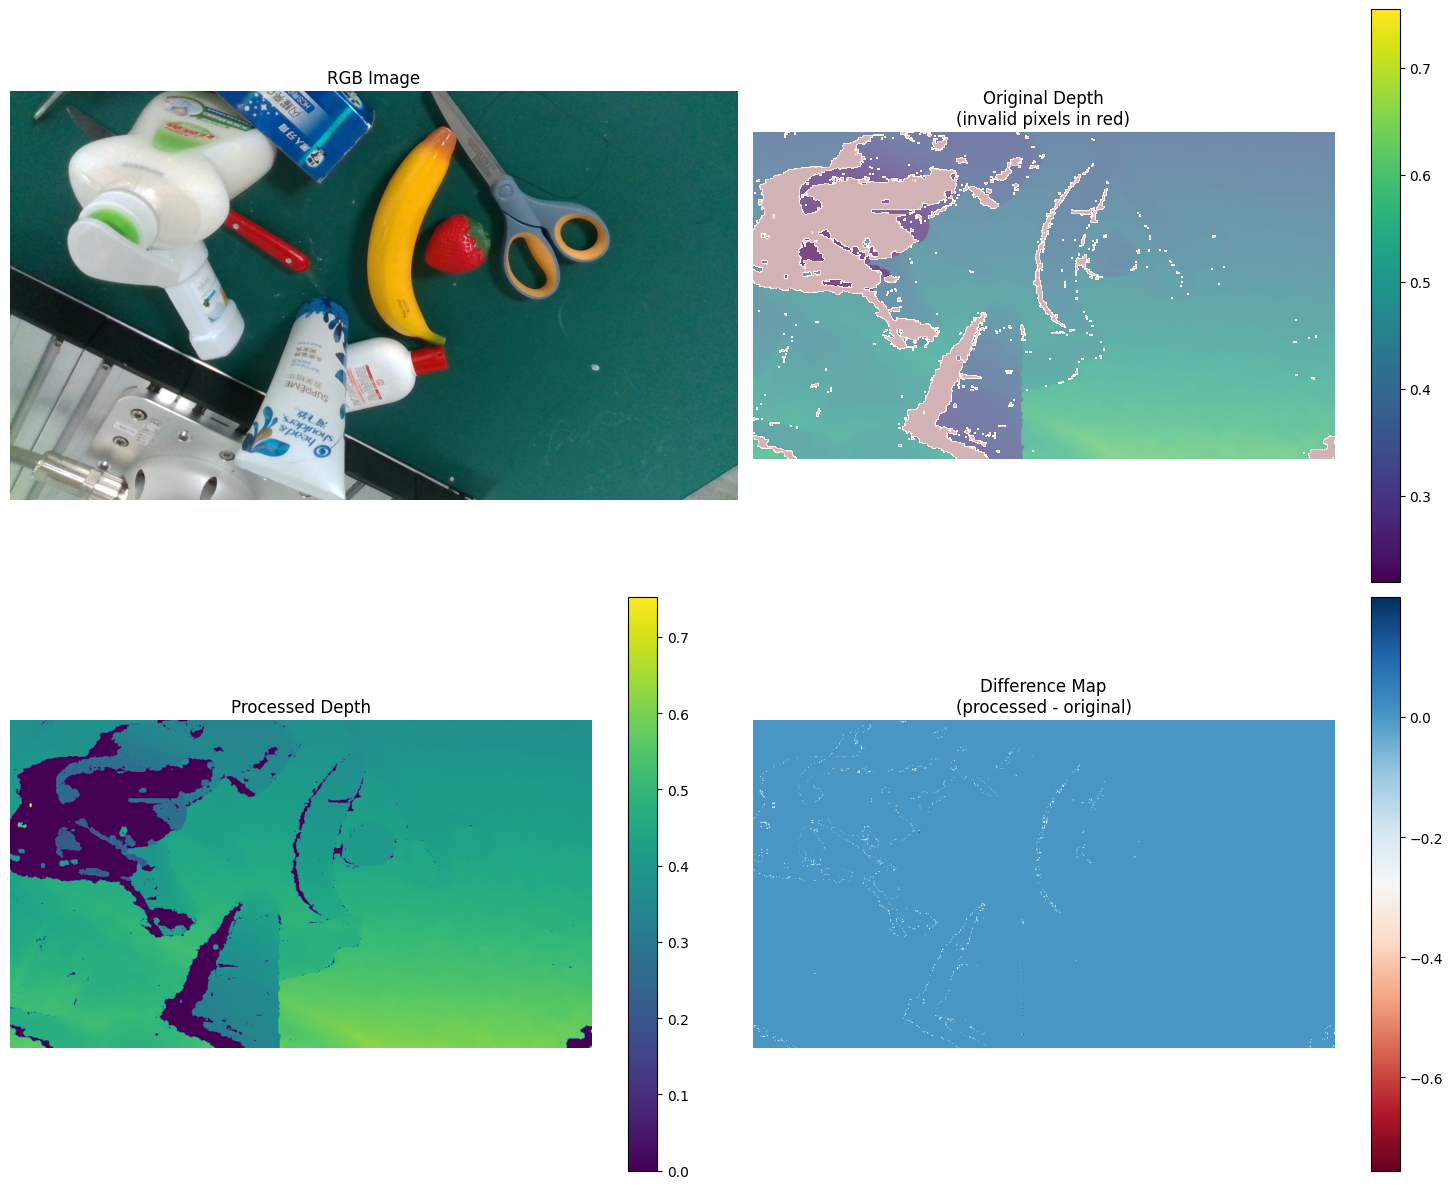

In [24]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

def analyze_depth(depth_img):
    """Analyze depth image statistics"""
    invalid_mask = (depth_img == 0)
    valid_pixels = depth_img[~invalid_mask]
    
    stats = {
        "total_pixels": depth_img.size,
        "invalid_pixels": np.sum(invalid_mask),
        "invalid_percentage": (np.sum(invalid_mask) / depth_img.size) * 100,
        "min_valid_depth": np.min(valid_pixels) if valid_pixels.size > 0 else 0,
        "max_valid_depth": np.max(valid_pixels) if valid_pixels.size > 0 else 0,
        "mean_valid_depth": np.mean(valid_pixels) if valid_pixels.size > 0 else 0
    }
    return stats

def gentle_depth_preprocessing(depth_img, max_depth=755):
    """
    Conservative depth preprocessing that preserves valid depth values
    """
    # Convert to float32
    depth = depth_img.astype(np.float32)
    
    # Create mask for invalid/zero values
    invalid_mask = (depth == 0)
    
    # Only process depth values within valid range (0-755mm for your case)
    valid_range_mask = (depth > 0) & (depth <= max_depth)
    
    # Create output depth image
    depth_processed = depth.copy()
    
    # Small median filter only on valid depths to remove noise
    # This preserves edges better than bilateral filter
    valid_depth = depth_processed.copy()
    valid_depth[~valid_range_mask] = 0
    filtered_valid = cv2.medianBlur(valid_depth.astype(np.float32), 5)
    depth_processed[valid_range_mask] = filtered_valid[valid_range_mask]
    
    return depth_processed, invalid_mask

def visualize_depth_comparison(rgb_img, original_depth, processed_depth, invalid_mask):
    """
    Visualize original and processed depth with invalid pixels highlighted
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # RGB image
    axes[0,0].imshow(rgb_img)
    axes[0,0].set_title('RGB Image')
    axes[0,0].axis('off')
    
    # Original depth with invalid pixels in red
    depth_vis = original_depth.copy()
    depth_vis = np.ma.masked_where(invalid_mask, depth_vis)
    im1 = axes[0,1].imshow(depth_vis, cmap='viridis')
    axes[0,1].imshow(invalid_mask, cmap='Reds', alpha=0.3)
    axes[0,1].set_title('Original Depth\n(invalid pixels in red)')
    axes[0,1].axis('off')
    plt.colorbar(im1, ax=axes[0,1])
    
    # Processed depth
    im2 = axes[1,0].imshow(processed_depth, cmap='viridis')
    axes[1,0].set_title('Processed Depth')
    axes[1,0].axis('off')
    plt.colorbar(im2, ax=axes[1,0])
    
    # Depth difference
    diff = processed_depth - original_depth
    im3 = axes[1,1].imshow(diff, cmap='RdBu')
    axes[1,1].set_title('Difference Map\n(processed - original)')
    axes[1,1].axis('off')
    plt.colorbar(im3, ax=axes[1,1])
    
    plt.tight_layout()
    return fig

def process_and_analyze_depth(val_dir):
    """
    Process depth images and analyze results
    """
    depth_dir = os.path.join(val_dir, "depth")
    img_dir = os.path.join(val_dir, "images")
    
    for img_name in os.listdir(depth_dir):
        try:
            # Load depth and RGB images
            depth_path = os.path.join(depth_dir, img_name)
            img_path = os.path.join(img_dir, img_name)
            
            depth = cv2.imread(depth_path, cv2.IMREAD_ANYDEPTH)/1000.0
            if depth is None:
                print(f"Failed to load depth image: {depth_path}")
                continue
                
            rgb = np.array(Image.open(img_path))
            
            print(f"\nProcessing: {img_name}")
            
            # Analyze original depth
            original_stats = analyze_depth(depth)
            print("\nOriginal Depth Statistics:")
            print(f"Invalid pixels: {original_stats['invalid_percentage']:.2f}%")
            print(f"Valid depth range: {original_stats['min_valid_depth']:.1f} - {original_stats['max_valid_depth']:.1f}")
            
            # Process depth
            processed_depth, invalid_mask = gentle_depth_preprocessing(depth)
            
            # Analyze processed depth
            processed_stats = analyze_depth(processed_depth)
            print("\nProcessed Depth Statistics:")
            print(f"Invalid pixels: {processed_stats['invalid_percentage']:.2f}%")
            print(f"Valid depth range: {processed_stats['min_valid_depth']:.1f} - {processed_stats['max_valid_depth']:.1f}")
            
            # Visualize results
            fig = visualize_depth_comparison(rgb, depth, processed_depth, invalid_mask)
            plt.show()
            
            # # Save option
            # save = input("Save processed depth? (y/n): ")
            # if save.lower() == 'y':
            #     output_dir = os.path.join(val_dir, "processed_depth")
            #     os.makedirs(output_dir, exist_ok=True)
            #     output_path = os.path.join(output_dir, img_name)
            #     cv2.imwrite(output_path, processed_depth.astype(np.uint16))
            #     print(f"Saved to: {output_path}")
            
            # next_img = input("Continue to next image? (y/n): ")
            # if next_img.lower() != 'y':
            #     break
                
            plt.close(fig)
            break
            
        except Exception as e:
            print(f"Error processing {img_name}: {str(e)}")
            continue

if __name__ == "__main__":
    val_dir = os.path.join(data_dir , "val")  # Replace with your directory path
    process_and_analyze_depth(val_dir)